In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/train.csv", index_col="id")
val_df = pd.read_csv("data/val.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31500
val size 2700
test size 10800


In [4]:
train_df.sample(10)

,text,label
id,,
12325,SSD discretizes the output space of bounding b...,3
14437,quantization is an effective method for reduci...,3
7492,deep-networks-based hashing has become a leadi...,3
6174,"in order to understand its magnitude, we prese...",3
1754,cell microscopy sequences exhibit complex spat...,3
29633,this paper presents a hierarchical framework b...,2
12843,we propose and validate a composite kernel loc...,3
28258,domain adaptive image retrieval includes singl...,3
24081,there are two quaternion multiplications in co...,2


<AxesSubplot:>

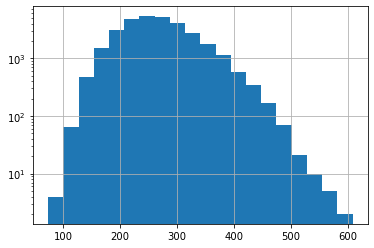

In [5]:
text_lengths = train_df["text"].apply(len)
text_lengths.hist(log=True, bins=20)

<AxesSubplot:>

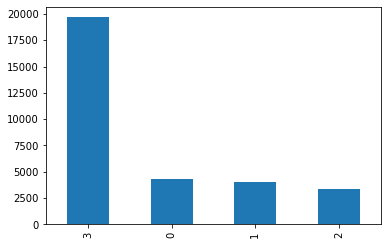

In [6]:
train_df["label"].value_counts().plot(kind="bar")

<AxesSubplot:>

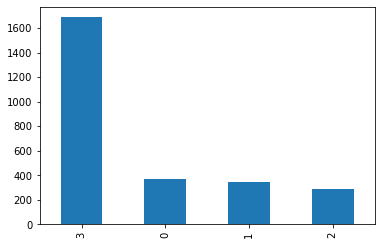

In [7]:
val_df["label"].value_counts().plot(kind="bar")

In [8]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [9]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=1024, truncation=True, padding=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=1024, truncation=True, padding=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=1024, truncation=True, padding=True)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

In [11]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=512,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.409600,0.363448
2,0.307100,0.333452
3,0.244500,0.333853


In [12]:
model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-372")
model = model.cuda()
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [14]:
results = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.cuda() for k,v in batch.items()}
        output = model(**batch)
        results.append(output["logits"].cpu())

In [15]:
results = torch.cat(results)
results = torch.argmax(results, dim=1)
results

tensor([3, 2, 3,  ..., 1, 2, 3])

In [16]:
submission = test_df.copy()
submission["label"] = results.numpy()
submission

,text,label
id,,
0,we propose a lightweight framework to detect i...,3
1,the proposed method presents an alternate solu...,2
2,proposed ear identification method fusing SIFT...,3
3,a method to reconstruct the three-dimensional ...,3
4,strong local consistencies can improve their p...,0
...,...,...
10795,whole-body gradient echo scans of 240 subjects...,3
10796,we present a tracker that accomplishes trackin...,3
10797,the most popular FL algorithm is Federated Ave...,1


In [17]:
submission.to_csv("submission.csv")